# Practicing coding:


CJ Monson


### Importing packages:

In [1]:
from astropy.io import fits #imports fits package > this allows the opening of fits files  
import numpy as np #imports numpy
import matplotlib.pyplot as plt
import seaborn as sns # provides a high-level interface to draw statitistical graphics
from pylab import *
%config InlineBackend.figure_format = 'retina' #makes images clearer
%matplotlib inline 
#^put plots in line?


In [2]:
sns.set_context('notebook')

In [3]:
!ls -1 ../Desktop/C_A_Files/ #lists the files in the directory of the files of choice

SDCH_20150425_0064.sn.fits
SDCH_20150425_0064.spec_a0v.fits
SDCH_20150425_0064.variance.fits
SDCH_20150425_0072.variance.fits
subsub_checking_new_data.ipynb


In [4]:
hdu = fits.open("../Desktop/C_A_Files/SDCH_20150425_0064.spec_a0v.fits") 
# opens ...spec_a0v.fits from Desktop and calls it hdu

In [5]:
var = fits.open("../Desktop/C_A_Files/SDCH_20150425_0064.variance.fits")
# opens ...variance.fits from Desktop and calls it var

In [6]:
hdu.info() # gets info from spec_a0v

Filename: ../Desktop/C_A_Files/SDCH_20150425_0064.spec_a0v.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SPEC_DIVIDE_A0V    1 PrimaryHDU     183   (2048, 28)   float64   
  1  WAVELENGTH    1 ImageHDU       184   (2048, 28)   float64   
  2  TGT_SPEC      1 ImageHDU       184   (2048, 28)   float32   
  3  A0V_SPEC      1 ImageHDU       184   (2048, 28)   float32   
  4  VEGA_SPEC     1 ImageHDU       184   (2048, 28)   float64   


In [7]:
var.info() # displays the info from variance

Filename: ../Desktop/C_A_Files/SDCH_20150425_0064.variance.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     181   (2048, 28)   float32   


In [8]:
dat = hdu[0] #looks at the 0th entry of hdu and calls it dat (hdu = Header Data Unit?)
wav = hdu[1] #looks at the 1st entry of hdu and calls it wav (WAVELENGTH)

In [9]:
# Order 110,113,115; I am not sure the significance of 12, 15, 17 other than all being 98 less than the order#
# must be between 0 and 28
o110 = 12
o113 = 15
o115 = 17

In [10]:
dat.data[o110]
dat.data[o113]
dat.data[o115]
#looks at the data within 'dat'. it is currently and array of NaNs


array([nan, nan, nan, ..., nan, nan, nan])

## Derive the A0 corrected sigma from the variance

In [11]:
# Scale factors
scale_factor115 = hdu[3].data[o115]/hdu[4].data[o115]
scale_factor113 = hdu[3].data[o113]/hdu[4].data[o113]
scale_factor110 = hdu[3].data[o110]/hdu[4].data[o110]

(0, 5000)

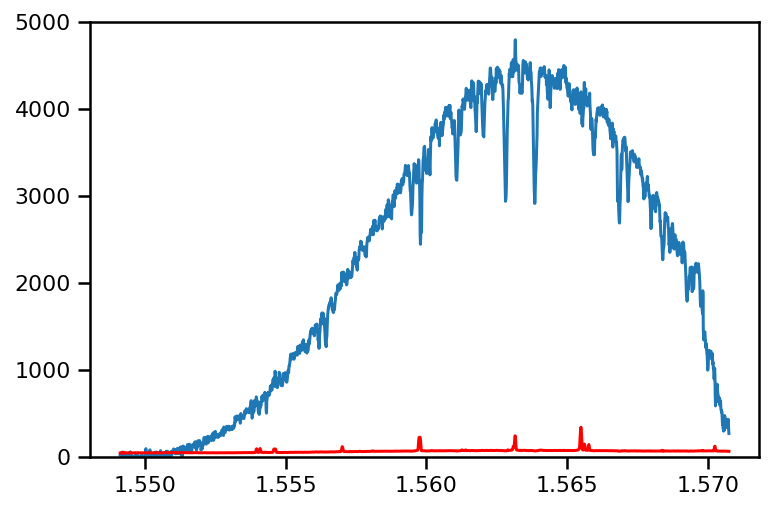

In [12]:
# Make a plot of order 115
plt.plot(hdu[1].data[o115], hdu[2].data[o115]) #Wavelength by TGT_Spec
plt.plot(hdu[1].data[o115], np.sqrt(var[0].data[o115]), color = 'red') #Wavelength by Primary
plt.ylim(0, 5000) #limits


In [13]:
np.nanmax(hdu[2].data[o115]/np.sqrt(var[0].data[o115]))*np.sqrt(3.5) #why 3.5?

120.05207295936641

(0, 800000.0)

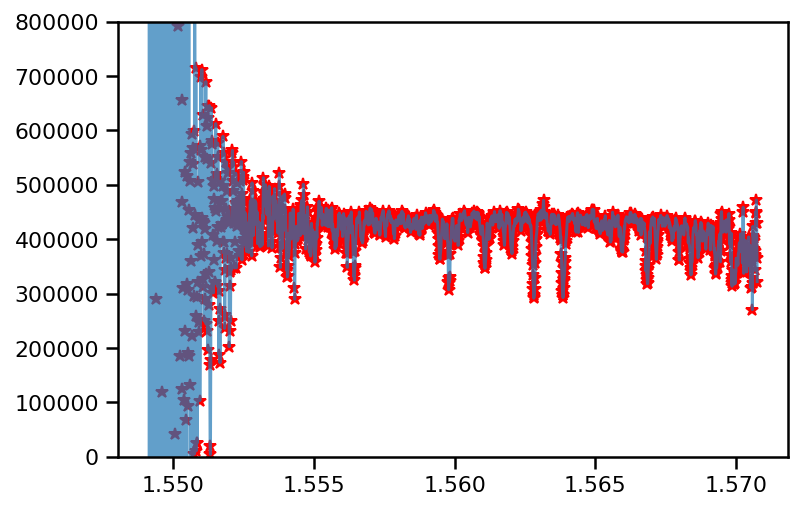

In [14]:
# initial plot with scale factor
plt.plot(hdu[1].data[o115], hdu[2].data[o115]/scale_factor115, 'r*')
plt.plot(hdu[1].data[o115], hdu[0].data[o115], alpha=0.7)
plt.ylim(0, 8.0e5)

In [15]:
# find sigma raw and then divide it by its scale factor
sig_raw115 = np.sqrt(var[0].data[o115]) # var[0]= primary
sig_raw113 = np.sqrt(var[0].data[o113])
sig_raw110 = np.sqrt(var[0].data[o110])
sig_scaled115 = sig_raw115/scale_factor115 
sig_scaled113 = sig_raw110/scale_factor113 # changed raw110-> raw113
sig_scaled110 = sig_raw110/scale_factor113 # changed factor113 -> factor110


## Signal to Noise ratio = take the NaN median of TGT_Spec of each order divided by the A0v_spec divided by VEGA_spec

In [16]:
signal_115 = hdu[2].data[o115]/scale_factor115
noise115 = sig_scaled115
median_S_N115 = np.nanmedian(signal_115/noise115)
print("Median Signal-Noise ratio of Order 115: {:0.5f} per pixel".format(median_S_N115))

Median Signal-Noise ratio of Order 115: 39.99794 per pixel


In [17]:
signal_113 = hdu[2].data[o113]/scale_factor113
noise113 = sig_scaled113
median_S_N113 = np.nanmedian(signal_113/noise113)
print("Median Signal-Noise ratio of Order 113: {:0.6} per pixel".format(median_S_N113))

Median Signal-Noise ratio of Order 113: 43.1344 per pixel


In [18]:
signal_110 = hdu[2].data[o110]/scale_factor110
noise110 = sig_scaled110
median_S_N110 = np.nanmedian(signal_110/noise110)
print("Median Signal-Noise ratio of Order 110: {:0.30f} per pixel".format(median_S_N110))

Median Signal-Noise ratio of Order 110: 41.637263482193993979763035895303 per pixel


# Order 110

In [19]:
# Working towards a nicer graph than the one seen above [out 42, currently]
flux110 = dat.data[o110]
fluxcut110 = flux110[~np.isnan(flux110)]
wave110 = wav.data[o110]
wavecut110 = wave110[~np.isnan(flux110)]
sig110 = sig_scaled110
sigcut110 = sig110[~np.isnan(flux110)]


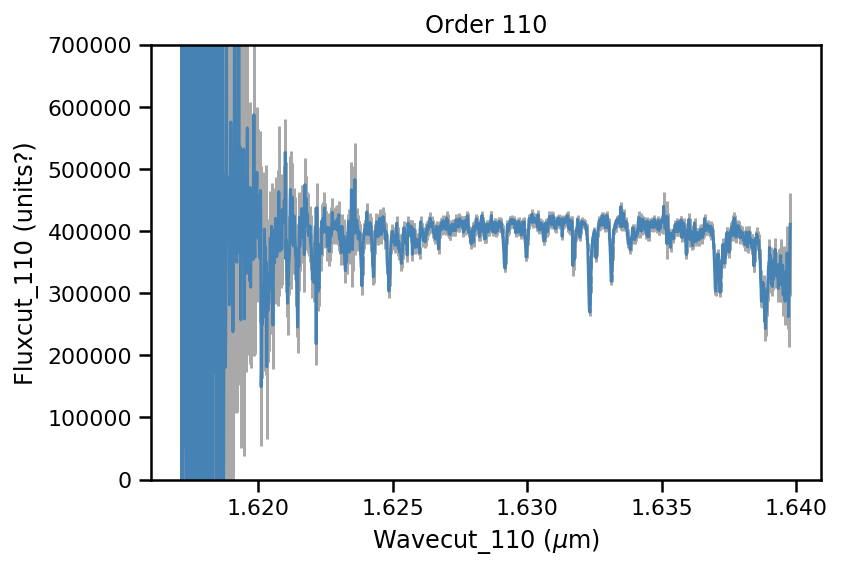

In [20]:
plt.errorbar(wavecut110, fluxcut110, yerr=sigcut110, color="steelblue",
             ecolor="darkgray")

plt.ylim(0, 7e5)
plt.title("Order 110")
plt.xlabel("Wavecut_110 ($\mu$m)")
plt.ylabel("Fluxcut_110 (units?)")
plt.show()
#fig = plt.Figure(figsize =(6,4))
#ax = fig.add_subplot(111)



## Trim noisy section and convert microns to Angstroms

In [21]:
#trims out noisy stuff (the big blue band of brightness)

In [22]:
gi110 = (wavecut110 > 1.623) & (wavecut110 < 1.640) # gi110 = wavecuts bigger than 1.623 and smaller that 1.640

In [23]:
gi110.sum() #take the sum of gi110

1559

In [24]:
#simplify commands
wl_110 = wavecut110
fl_110 = fluxcut110
sg_110 = sigcut110

In [25]:
#take cuts and set to gi110 (which equals 1559)
fls_out110 = fl_110[gi110]
sig_out110 = sg_110[gi110]
wls_out110 = wl_110[gi110]*10000.0 #(convert to angstroms)
msk_out110 = np.ones(len(wls_out110), dtype=int) # np.ones -> Return a new array of given shape and type, 
#...filled with new ones



## Scale the absolute value down to ~1.0 for ease of plottingg

In [26]:
med_fls110 = np.median(fls_out110) #takes the median of fls110 and sets equal to med_fls110
fls_out110 = fls_out110 / med_fls110 #redefines fls110 as fls110/medfls110
sig_out110 = sig_out110 / med_fls110 # redefines sig110

<ErrorbarContainer object of 3 artists>

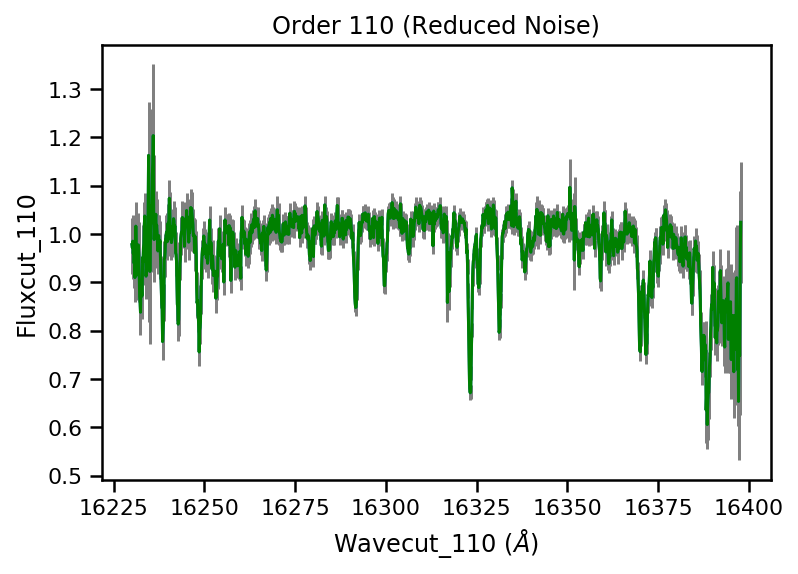

In [27]:
#creates a plot with labels
plt.title("Order 110 (Reduced Noise)")
plt.xlabel("Wavecut_110 ($\AA$)")
plt.ylabel("Fluxcut_110")
plt.plot(wls_out110, fls_out110) # plots wavecut(angstroms) by fluxcut (median)
plt.errorbar(wls_out110, fls_out110, yerr=sig_out110, color = "green", ecolor = "gray")


In [28]:

import h5py #allows for the storage of more data

In [29]:
# I do not know what file this is. It does not appear on any files
m = 110
out_name110 = '..'



## Order 113

In [30]:
# Working towards a nicer graph than the one seen above 
flux113 = dat.data[o113]
fluxcut113 = flux113[~np.isnan(flux113)]
wave113 = wav.data[o113]
wavecut113 = wave113[~np.isnan(flux113)]
sig113 = sig_scaled113
sigcut113 = sig113[~np.isnan(flux113)]

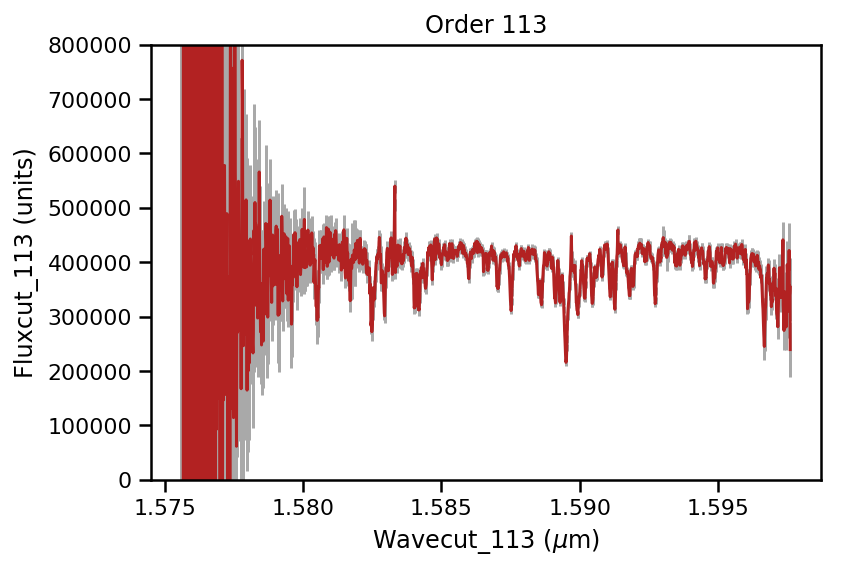

In [31]:
plt.errorbar(wavecut113, fluxcut113, yerr=sigcut113, color="firebrick",
             ecolor="darkgray")

plt.ylim(0, 8e5)
plt.title("Order 113")
plt.xlabel("Wavecut_113 ($\mu$m)")
plt.ylabel("Fluxcut_113 (units)")
plt.show()
#fig = plt.Figure(figsize =(6,4))
#ax = fig.add_subplot(111)

## Trim noisy section and convert microns to Angstroms

In [32]:
#trims out noisy stuff (the ridiculous red ribbon of rage)

In [33]:
gi113 = (wavecut113 > 1.5805) & (wavecut113 < 1.597) # gi110 = wavecuts bigger than 1.623 and smaller that 1.640

In [34]:
gi113.sum()

1564

In [35]:
#simplify commands
wl_113 = wavecut113
fl_113 = fluxcut113
sg_113 = sigcut113

In [36]:
#take cuts and set to gi110 (which equals 1559)
fls_out113 = fl_113[gi113]
sig_out113 = sg_113[gi113]
wls_out113 = wl_113[gi113]*10000.0 #(convert to angstroms)
msk_out113 = np.ones(len(wls_out113), dtype=int) # np.ones -> Return a new array of given shape and type... 
#...filled with new ones

## Scale the absolute value down to ~1.0 for ease of plottingg

In [37]:
med_fls113 = np.median(fls_out113) #takes the median of fls113 and sets equal to med_fls113
fls_out113 = fls_out113 / med_fls113 #redefines fls113 as fls113/medfls113
sig_out113 = sig_out113 / med_fls113 # redefines sig113

<ErrorbarContainer object of 3 artists>

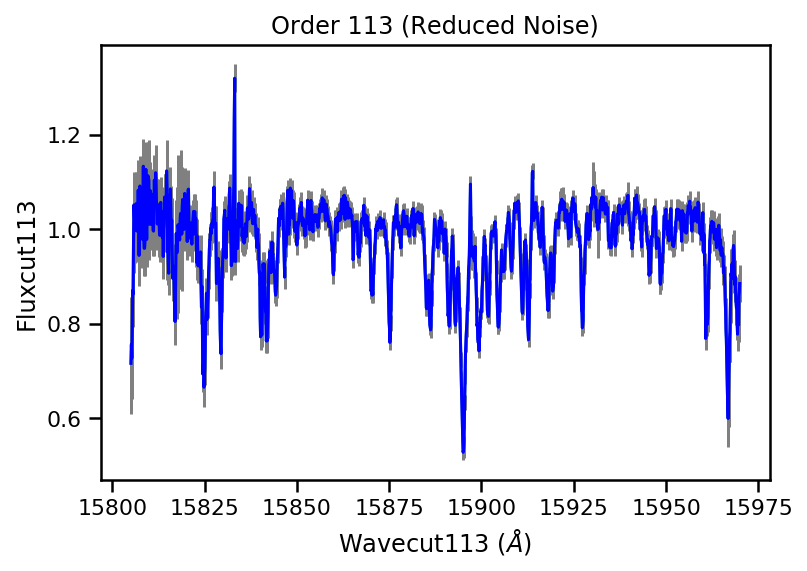

In [38]:
# created a plot of order 113 and gave it labels
plt.title("Order 113 (Reduced Noise)")
plt.xlabel("Wavecut113 ($\AA$)")
plt.ylabel("Fluxcut113")
plt.plot(wls_out113, fls_out113) # plots wavecut(angstroms) by fluxcut (median)
plt.errorbar(wls_out113, fls_out113, yerr=sig_out113, color = "blue", ecolor = "gray")

# Order 115

In [39]:
# making a graph of order 115
flux115 = dat.data[o115]
fluxcut115 = flux115[~np.isnan(flux115)]
wave115 = wav.data[o115]
wavecut115 = wave115[~np.isnan(flux115)]
sig115 = sig_scaled115
sigcut115 = sig115[~np.isnan(flux115)]


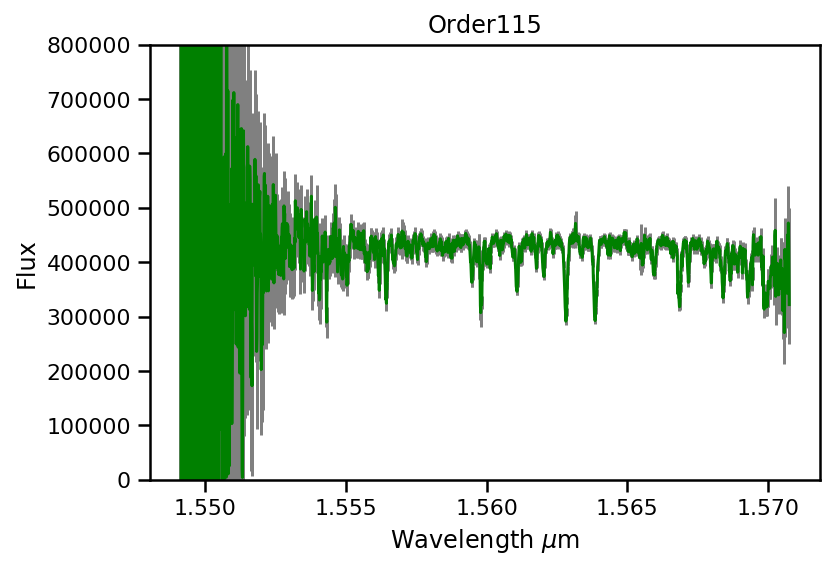

In [40]:
plt.errorbar(wavecut115, fluxcut115,yerr=sigcut115, color = "green", ecolor = "gray")
plt.ylim(0,8e5)
plt.xlabel("Wavelength $\mu$m")
plt.ylabel("Flux")
plt.title("Order115")
plt.show()


### Trim NaNs

In [41]:
wavecut115.shape, fluxcut115.shape, sigcut115.shape

((2040,), (2040,), (2040,))

In [42]:
bi = (fluxcut115 != fluxcut115) | (sigcut115 != sigcut115) 
len(bi), bi.sum()


(2040, 0)

### Trimming npisy data


In [43]:
td115 = (wavecut115 > 1.553) & (wavecut115 < 1.572) #td (trim data)
td115.sum()

1711

In [44]:
# renaming wc(wave cut)
wc_115 = wavecut115
fc_115 = fluxcut115
sc_115 = sigcut115

In [45]:
fcs_out115 = fc_115[td115]
scs_out115 = sc_115[td115]
wcs_out115 = wc_115[td115]*10000.0 #convert to angstroms
msk_out115 = np.ones(len(wcs_out115), dtype=int) 

### Scale the absolute values down to ~1.0, eases plotting

In [46]:
med_fcs115 = np.median(fcs_out115)
fcs_out115 = fcs_out115 / med_fcs115
scs_out115 = scs_out115 / med_fcs115

<ErrorbarContainer object of 3 artists>

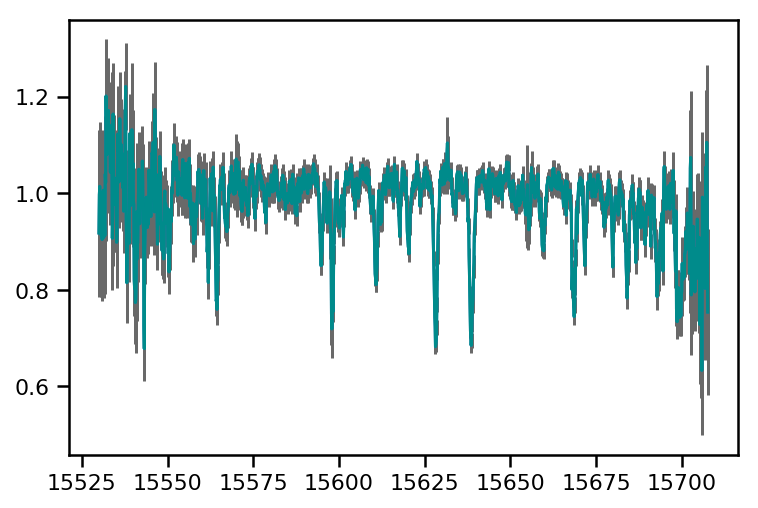

In [47]:
plt.plot(wcs_out115, fcs_out115)
plt.errorbar(wcs_out115, fcs_out115, yerr=scs_out115, color = "darkcyan", ecolor="dimgray")

## Creating a file

In [48]:
# Test run 2
wc115 = ""
fc115 = ""
sc115 = ""
ePerc = ""
#print(len(wavecut115))
#print(len(fluxcut115))
#print(len(sigcut115))
#print(wavecut115[200])
#print(wave115[2039])
def fileOutput2(a,b,c):
    length = 2040
    wc115 = wavecut115
    fc115 = fluxcut115
    sc115 = sigcut115
    ePerc = (sigcut115/fluxcut115) *100
    file = open('ListFinal.txt', 'w')
    #file.write("%0s %10s %25s\n"%("Wavelength","Flux", "FluxError"))
    for i in range(length): # for loop to create a list of columns
        file.write("%0.5f %20.5f %20.5f\n"% (wc115[i], fc115[i], sc115[i]))
        #file.write("%0.5f %20.5f %20.5f %20.5f%s\n"% (wc115[i], fc115[i], sc115[i], ePerc[i], "%" )) 
        #file.write("{wc115}")
    file.close()
fileOutput2(wc115, fc115, sc115) 


## Reading in and analyzing a file

### Taking in a file and reading it. Rename it

In [49]:
wavecut_out115, fluxcut_out115, sigcut_out115 = np.loadtxt('ListFinal.txt',  unpack=True)
wcs_out115 = wavecut_out115
fcs_out115 = fluxcut_out115
scs_out115 = sigcut_out115



### Create a graph of ALL of the data

1.57075
98344993.09827
-86211434.86202


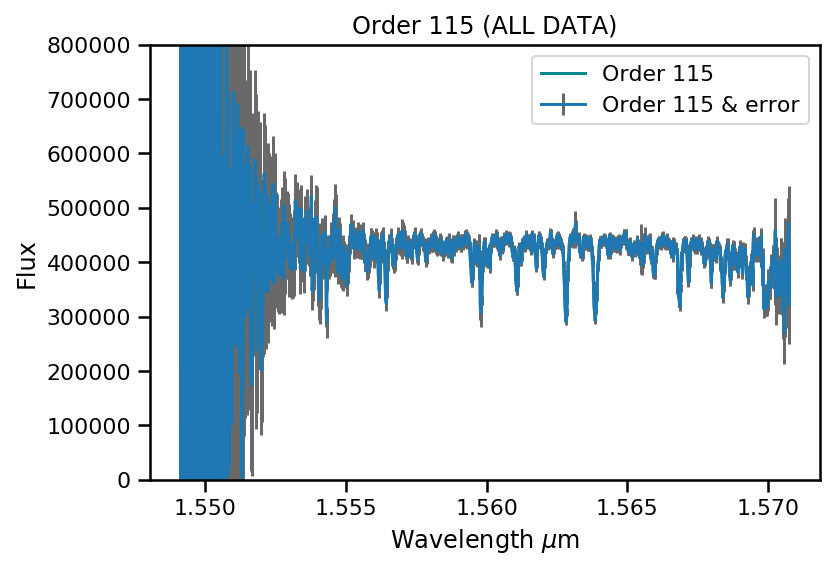

In [50]:
### Without trimming

plt.plot(wcs_out115, fcs_out115, color = "darkcyan", label = "Order 115")
plt.errorbar(wcs_out115, fcs_out115, yerr=scs_out115,  ecolor="dimgray", label = "Order 115 & error")


plt.ylim(0,8e5)
plt.xlabel("Wavelength $\mu$m")
plt.ylabel('Flux')
plt.title("Order 115 (ALL DATA)")
plt.legend()
plt.show
print(max(wcs_out115))
print(max(fcs_out115))
print(min(fcs_out115))

#print(" max value: 0.5f% 0.5f%"% max(wcs_out115), max(fcs_out115) )

# Taking info in and spitting it out on a graph.

In [51]:

wavecut115s, fluxcut115s, sigcut115s = np.loadtxt('ListFinal.txt',  unpack=True)

# try trimming here:
tds115 = (wavecut115s > 1.553) & (wavecut115s < 1.572) #td (trim data)
print(tds115.sum())
# Rename
wcs2_115 = wavecut115s
fcs2_115 = fluxcut115s
scs2_115 = sigcut115s


#print(" max value: 0.5f% 0.5f%"% max(wcs_out115), max(fcs_out115) )

1710


## Cut out what is not included in td115

In [52]:
### With trimming
fcs2_out115 = fcs2_115[tds115]
scs2_out115 = scs2_115[tds115]
wcs2_out115 = wcs2_115[tds115]#*10000.0 #convert to angstroms
msk_out115 = np.ones(len(wcs_out115), dtype=int) 

med_fcs115 = np.median(fcs_out115)
fcs_out115 = fcs_out115 / med_fcs115
scs_out115 = scs_out115 / med_fcs115

## Plot altered graph. (no large spike in beginning)

1.57075
521369.3391
270432.35775


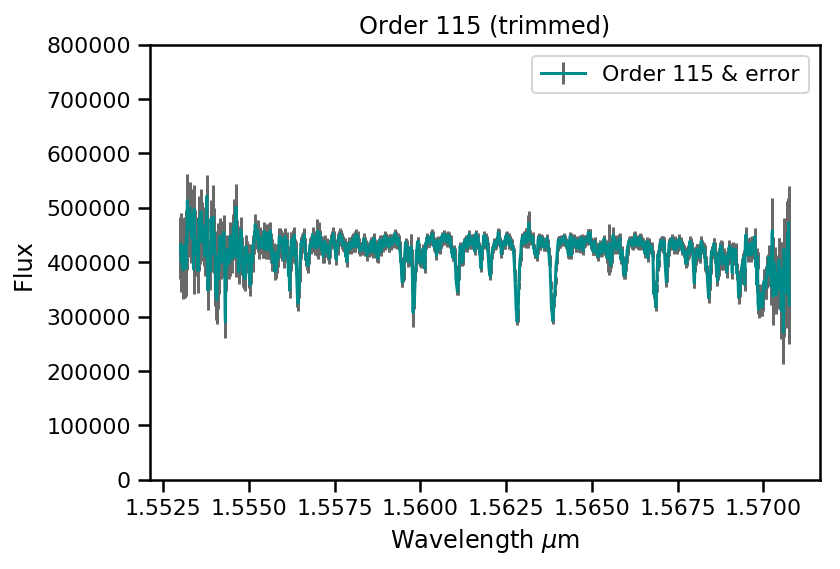

In [53]:
#plt.plot(wcs_out115, fcs_out115)
plt.errorbar(wcs2_out115, fcs2_out115, yerr=scs2_out115, color = "darkcyan", ecolor="dimgray", 
             label = "Order 115 & error")
# End trimming



plt.ylim(0,8e5)
plt.xlabel("Wavelength $\mu$m")
plt.ylabel('Flux ')
plt.title("Order 115 (trimmed)")
plt.legend()
plt.show
print(max(wcs2_out115))
print(max(fcs2_out115))
print(min(fcs2_out115))

## Tests and Practice: Creating txt files and reading them 



In [54]:
#practicing saving an answer as a text file. 

def add(a,b): # defines a function
    #sum = a + b # adds a and b 
    file = open('answer1.txt', 'a') # creates and opens a file called "answer.txt" 
    file.write(f'{a} {b}\n') # adds string to file
    file.close() #closes the file
add(3,4) # adds two numbers
add(2,5)
add(10,4)
add(3,4) # adds two numbers
add(6,5)
add(9,3)
add(3,7) # adds two numbers
add(8,5)
add(9,2)

# This worked. It created a file in the same directory as this code (/Desktop/..)


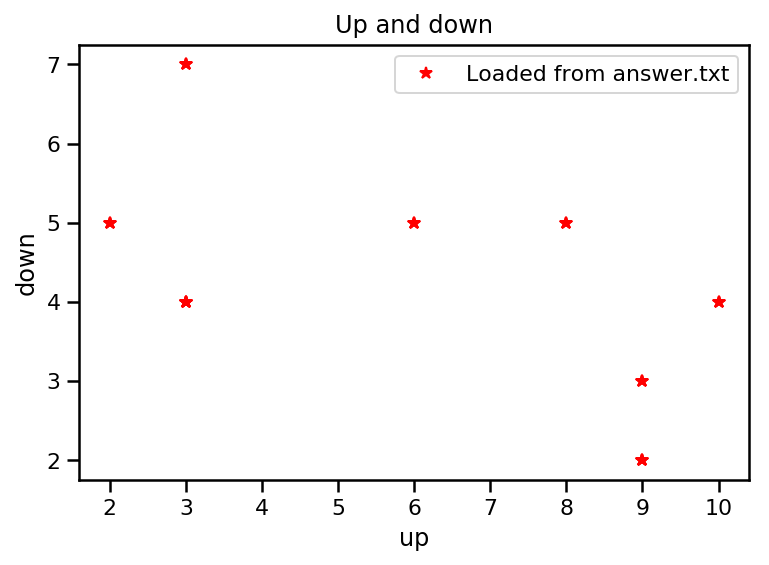

In [59]:
# Practice2


x, y = np.loadtxt('answer1.txt', unpack=True)
plt.plot(x,y, 'r*', label = 'Loaded from answer.txt')

plt.xlabel("up")
plt.ylabel("down")
plt.title("Up and down")
plt.legend()

plt.show()

In [56]:
# Practice reading a file in:
# use the file with numbers first [1..9]
file = open('answer.txt', 'r')
#print(file.read())


In [57]:
# Test run 1
def fileOutput(a):
    
    file = open('TestStuff', 'w') #writes to file
    file.write(f' Wavelength'   ) # was supposed to call one column "wavelength"
    file.write(f' {a}\n') # adds info
    file.close() # closes
fileOutput(wavecut115) # adds info from wavecut115
#Does not make columns. This places all the numbers in brackets and...
# ...places them in a line.

In [58]:
# Practice2: gets numbers into columns and spaces them out
up = ""
down = ""
def fileOutput1(a,b):
    up = [1,2,3,4,5,6,7,8,9]
    down = [9,8,7,6,5,4,3,2,1]
    file = open('TestStuff1', 'w')
    for i in range(len(up)): # for loop to create a list of columns
        #file.write(f' {i} {up[i]} {down[i]}')
        file.write("%i %15.2f\n"% (up[i], down[i]))
    file.close()
fileOutput1(up, down) # worked! created two columns 7 spaces apart

                   

In [62]:
# Test run 2
wc115 = ""
fc115 = ""
sc115 = ""
ePerc = ""
#print(len(wavecut115))
#print(len(fluxcut115))
#print(len(sigcut115))
#print(wavecut115[200])
#print(wave115[2039])
def fileOutput3(a,b,c):
    length = 2040
    wc115 = wavecut115
    fc115 = fluxcut115
    sc115 = sigcut115
    ePerc = (sigcut115/fluxcut115) *100
    file = open('Test3.txt', 'w')
    file.write("%0s %10s %25s %20s\n"%("Wavelength","Flux", "FluxError", "Error%"))
    for i in range(length): # for loop to create a list of columns
        #file.write("%0.5f %20.5f %20.5f\n"% (wc115[i], fc115[i], sc115[i]))
        file.write("%0.5f %20.5f %20.5f %18.5f%s\n"% (wc115[i], fc115[i], sc115[i], ePerc[i], "%" )) 
        #file.write("{wc115}")
    file.close()
fileOutput3(wc115, fc115, sc115) 